In [1]:
# Modules
#------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

# from scipy.integrate import solve_ivp
# from scipy.special import gamma, airy

In [23]:
dt = 3                           # time step, delta t
tmax = 25                             # max time, s
t = np.linspace(0, tmax, num=int(tmax/dt)) # time vector

columns = ['A', 'B', 'C', 'D', 'E']
exp_data = pd.DataFrame(columns=columns)


def rates(c, t):
    """
    w = wood-oil as conc[0]
    nv = non-volatiles as conc[1]
    v = volatiles as conc[2]
    """
    K1 = 0.8
    K2 = 0.1
    K3 = 0.01
    K4 = 0.01
    r0 = -K1 * c[0]
    r1 = K1 * c[0] - K2 * c[1] - K3 * c[1]
    r2 = K2 * c[1] - K4 * c[2]
    r3 = K3 * c[1]
    r4 = K4 * c[2]
    return [r0, r1, r2, r3, r4]

datasets = []

for i in range(5):
    ini_A = np.random.uniform(0.5, 1)
    ini_B = np.random.uniform(0, 0.5)
    ini_C = np.random.uniform(0, 0.5)
    ini_D = np.random.uniform(0, 0.1)
    ini_E = np.random.uniform(0, 0.1)
    
    cc = odeint(rates, [ini_A, ini_B, ini_C, ini_D, ini_E], t)

    exp_data = pd.DataFrame()
    exp_data['Time(s)'] = t
    for col in columns:
        exp_data[col] = pd.DataFrame(cc, columns=columns)[col]

    datasets.append(exp_data)
    
datasets

[     Time(s)             A         B         C         D         E
 0   0.000000  5.216707e-01  0.460936  0.406316  0.022225  0.086953
 1   3.571429  2.996091e-02  0.684792  0.631433  0.046576  0.105339
 2   7.142857  1.720734e-03  0.483777  0.813802  0.067417  0.131383
 3  10.714286  9.882574e-05  0.327842  0.925794  0.081740  0.162625
 4  14.285714  5.675874e-06  0.221405  0.988339  0.091425  0.196925
 5  17.857143  3.260903e-07  0.149480  1.017827  0.097964  0.232829
 6  21.428571  1.892166e-08  0.100918  1.025435  0.102379  0.269368
 7  25.000000  4.253919e-10  0.068132  1.018704  0.105359  0.305905,
      Time(s)             A         B         C         D         E
 0   0.000000  6.949580e-01  0.435764  0.056157  0.052283  0.093240
 1   3.571429  3.991325e-02  0.791900  0.321408  0.079456  0.099724
 2   7.142857  2.292323e-03  0.563216  0.547712  0.103666  0.115516
 3  10.714286  1.316536e-04  0.381883  0.692176  0.120347  0.137864
 4  14.285714  7.561271e-06  0.257913  0.778584

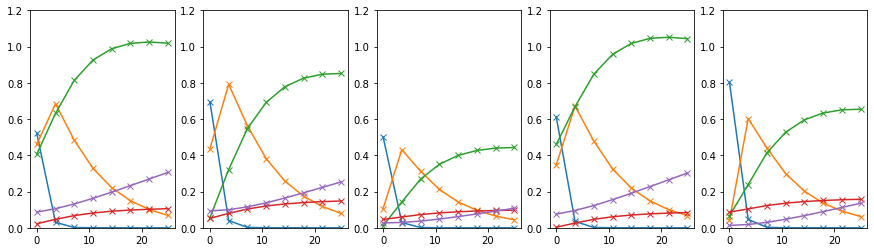

In [24]:
def example_plot(ax, plot_number, fontsize=12, hide_labels=False):
    for col in columns:
        ax.plot(datasets[plot_number]['Time(s)'], datasets[plot_number][col], label=col, marker='x')
        
    ax.set_ylim([0, 1.2])

number_of_plots = len(datasets) if len(datasets) < 5 else 5

fig, axs = plt.subplots(1, number_of_plots, figsize=(15,4), constrained_layout=False)
for i in range(len(axs)):
    example_plot(axs[i], plot_number=i)

## To regress the above data

In [62]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize, rosen, rosen_der
from scipy.optimize import differential_evolution
import warnings

# datasets


def sum_MSE(K):
    
    K1 = K[0]
    K2 = K[1]
    K3 = K[2]
    K4 = K[3]

    MSEs = []

    for i in range(len(datasets)):

        t = datasets[i]['Time(s)']
        yData = datasets[i].drop(['Time(s)'], axis=1).transpose().stack().reset_index(drop=True)
        for i in range(len(yData)):
            yData[i] = yData[i] * (1 + 0.1 * (numpy.random.random()-0.5)) # +- 5% relative error

        def func(t, ini_A, ini_B, ini_C, ini_D, ini_E):
            def rates(c, t):
                r0 = -K1 * c[0]
                r1 = K1 * c[0] - K2 * c[1] - K3 * c[1]
                r2 = K2 * c[1] - K4 * c[2]
                r3 = K3 * c[1]
                r4 = K4 * c[2]
                return [r0, r1, r2, r3, r4]

            cc = odeint(rates, [ini_A, ini_B, ini_C, ini_D, ini_E], t)

            return pd.DataFrame(cc).transpose().stack().reset_index(drop=True)


        # function for genetic algorithm to minimize (sum of squared error)
        def sumOfSquaredError(parameterTuple):
            warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
            val = func(t, *parameterTuple)
            return numpy.sum(numpy.sum((yData - val) ** 2.0))


        def generate_Initial_Parameters():
            # min and max used for bounds
            bound_ini_A = [0.5, 1]
            bound_ini_B = [0, 0.5]
            bound_ini_C = [0, 0.5]
            bound_ini_D = [0, 0.1]
            bound_ini_E = [0, 0.1]
            Bounds_initials = []
            Bounds_initials.append(bound_ini_A) # search bounds for initial concentration of A
            Bounds_initials.append(bound_ini_B) # search bounds for initial concentration of B
            Bounds_initials.append(bound_ini_C) # search bounds for initial concentration of C
            Bounds_initials.append(bound_ini_D) # search bounds for initial concentration of D
            Bounds_initials.append(bound_ini_E) # search bounds for initial concentration of E

            # "seed" the numpy random number generator for repeatable results
            result = differential_evolution(sumOfSquaredError, Bounds_initials, seed=3)

            return result.x


        # generate initial parameter values
        geneticParameters = generate_Initial_Parameters()

        # curve fit the test data
        fittedParameters, pcov = curve_fit(func, t, yData, geneticParameters)

#         print('Parameters', fittedParameters)

        modelPredictions = func(t, *fittedParameters) 

        absError = modelPredictions - yData
        SE = numpy.square(absError) # squared errors
        MSE = numpy.mean(SE) # mean squared errors
    #     RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    #     Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
    #     print('RMSE:', RMSE)
    #     print('R-squared:', Rsquared)

        MSEs.append(MSE)
    
    sum_MSE = numpy.sum(MSEs)
    print(sum_MSE)
    
    return sum_MSE

In [63]:
K0 = [0, 0, 0, 0]
minimize(sum_MSE, K0, method='Nelder-Mead')

0.1286977698651621
0.12870243407195497
0.12830684335269152
0.1284982092169468
0.12904142349137013
0.1280694719744231
0.1275963438973744
0.1278438650293825
0.12742567370874355
0.12679961964676736
0.12678617775428164
0.1259580390012657
0.12582753763552507
0.12466050035115665
0.12470068316851625
0.12352436234010294
0.12163115391978495
0.12183469736926017
0.12064443527838266
0.11836456220079408
0.11867473623379311
0.11615073228739842
0.1129375231496696
0.11408553849730907
0.11177408139942747
0.10942653612417133
0.10951144311122935
0.10779764673132372
0.10852454591373514
0.10830465821838614
0.10959474129775769
0.10836607099133266
0.10890661188694417
0.10959482351245795
0.10847722659678762
0.10880293827991006
0.10830638014985053
0.10786244322300936
0.1078925440484384
0.10772043153355129
0.1078178733599045
0.10725974116596892
0.10692081475918451
0.10730797950435764
0.10689413432664788
0.10663005700910891
0.10615986161840268
0.10540072176012172
0.10554966864994442
0.10580292982658357
0.1043863

 final_simplex: (array([[0.79993046, 0.10000011, 0.00999962, 0.01000001],
       [0.80002053, 0.09999962, 0.01000019, 0.01000067],
       [0.79996737, 0.10000119, 0.01000109, 0.01000048],
       [0.79992555, 0.09999938, 0.00999941, 0.01000057],
       [0.79995668, 0.09999703, 0.0100025 , 0.00999959]]), array([2.17058737e-11, 3.28481762e-11, 3.47351885e-11, 5.11821335e-11,
       8.23942850e-11]))
           fun: 2.170587367060341e-11
       message: 'Optimization terminated successfully.'
          nfev: 383
           nit: 229
        status: 0
       success: True
             x: array([0.79993046, 0.10000011, 0.00999962, 0.01000001])